# Combining Different Models for Ensemble Learning

### Goals:
* Make predictions based on majority voting
* Use bagging to reduce overfitting by drawing random combinations of the training set with repetition
* Apply boosting to build powerful models from weak learners that learn from their mistakes

### Learning with ensembles

In [1]:
from scipy.special import comb
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def ensemble_error(n_clasifier, error):
    k_start = int(math.ceil(n_clasifier/2))
    probs = [comb(n_clasifier, k)*error**(k)*(1-error)**(n_clasifier-k) for k in range(k_start, n_clasifier+1)]
    
    return sum(probs)

In [3]:
ensemble_error(11, 0.25)

0.03432750701904297

In [4]:
error_range = np.arange(0, 1.01, 0.01)
ens_errors = [ensemble_error(n_clasifier=11, error=error) for error in error_range]

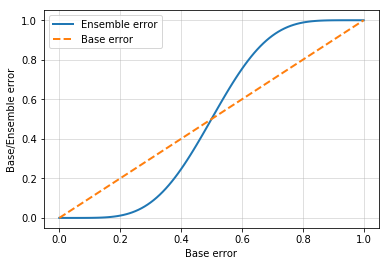

In [5]:
plt.plot(error_range, ens_errors, label='Ensemble error', linewidth=2)
plt.plot(error_range, error_range, linestyle='--', label='Base error', linewidth=2)
plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
plt.show()

### Combining classifiers via majority vote

In [6]:
np.argmax(np.bincount([0, 0, 1], weights=[0.2, 0.2, 0.6]))

1

In [7]:
ex = np.array([[0.9, 0.1], [0.8, 0.2], [0.4, 0.6]])
p = np.average(ex, axis=0, weights=[0.2, 0.2, 0.6])
print(p)
np.argmax(p)

[0.58 0.42]


0

In [8]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import operator

In [9]:
class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    """ A majority vote ensemble classifier

    Parameters
    ----------
    classifiers : array-like, shape = [n_classifiers]
      Different classifiers for the ensemble

    vote : str, {'classlabel', 'probability'}
      Default: 'classlabel'
      If 'classlabel' the prediction is based on
      the argmax of class labels. Else if
      'probability', the argmax of the sum of
      probabilities is used to predict the class label
      (recommended for calibrated classifiers).

    weights : array-like, shape = [n_classifiers]
      Optional, default: None
      If a list of `int` or `float` values are
      provided, the classifiers are weighted by
      importance; Uses uniform weights if `weights=None`.

    """
    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """ Fit classifiers.

        Parameters
        ----------
        X : {array-like, sparse matrix},
            shape = [n_samples, n_features]
            Matrix of training samples.

        y : array-like, shape = [n_samples]
            Vector of target class labels.

        Returns
        -------
        self : object

        """
        # Use LabelEncoder to ensure class labels start
        # with 0, which is important for np.argmax
        # call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
    
    def predict(self, X):
        """ Predict class labels for X.

        Parameters
        ----------
        X : {array-like, sparse matrix},
            Shape = [n_samples, n_features]
            Matrix of training samples.

        Returns
        ----------
        maj_vote : array-like, shape = [n_samples]
            Predicted class labels.

        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' vote

            #  Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x, weights=self.weights)),
                                           axis=1, arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """ Predict class probabilities for X.

        Parameters
        ----------
        X : {array-like, sparse matrix},
            shape = [n_samples, n_features]
            Training vectors, where n_samples is
            the number of samples and
            n_features is the number of features.

        Returns
        ----------
        avg_proba : array-like,
            shape = [n_samples, n_classes]
            Weighted average probability for
            each class per sample.

        """
        probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """ Get classifier parameter names for GridSearch"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return out


In [10]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [11]:
iris = datasets.load_iris()

In [12]:
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

In [13]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1, stratify=y)

In [14]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

In [15]:
clf1 = LogisticRegression(penalty='l2', C=0.001, random_state=1)
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')

In [16]:
pipe1 = Pipeline([['sc', StandardScaler()], 
                  ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()], 
                  ['clf', clf3]])


In [17]:
clf_labels = ['Logistic regression', 'Decision tree', 'KNN']
print('10-fold cross validation: \n')

for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf, X=x_train,
                            y=y_train, cv=10, scoring='roc_auc')
    
    print("ROC AUC: %0.2f (+/-%0.2f) [%s]"%(scores.mean(), scores.std(), label))

10-fold cross validation: 

ROC AUC: 0.87 (+/-0.17) [Logistic regression]
ROC AUC: 0.89 (+/-0.16) [Decision tree]
ROC AUC: 0.88 (+/-0.15) [KNN]


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

In [18]:
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])
clf_labels += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf, X=x_train,
                            y=y_train, cv=10,
                            scoring='roc_auc')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]"%(scores.mean(),
                                             scores.std(),
                                             label))



Accuracy: 0.87 (+/- 0.17) [Logistic regression]
Accuracy: 0.89 (+/- 0.16) [Decision tree]


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

Accuracy: 0.88 (+/- 0.15) [KNN]
Accuracy: 0.94 (+/- 0.13) [Majority voting]


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [19]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


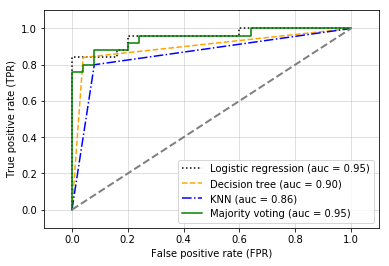

In [20]:
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']

for clf, label, clr, ls in zip(all_clf, clf_labels,
                              colors, linestyles):
    y_pred = clf.fit(x_train, y_train).predict_proba(x_test)[:,1]
    
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    
    roc_auc = auc(x=fpr, y=tpr)
    
    plt.plot(fpr, tpr, color=clr, linestyle=ls, 
             label='%s (auc = %0.2f)'%(label, roc_auc))
    
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], linestyle='--', 
         color='gray', linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.show()
    

In [21]:
from mlxtend.plotting import plot_decision_regions

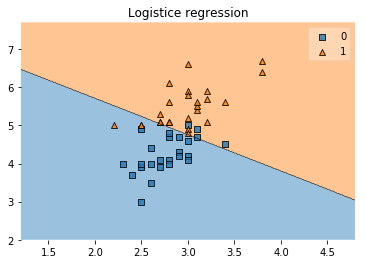

In [22]:
plot_decision_regions(x_train, y_train, clf=pipe1)
plt.title('Logistice regression')
plt.show()

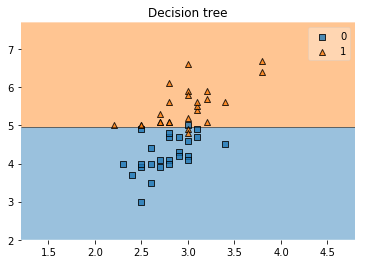

In [23]:
plot_decision_regions(x_train, y_train, clf=clf2)
plt.title('Decision tree')
plt.show()

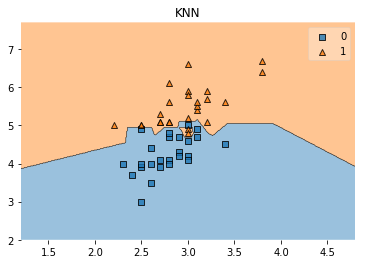

In [24]:
plot_decision_regions(x_train, y_train, clf=pipe3)
plt.title('KNN')
plt.show()

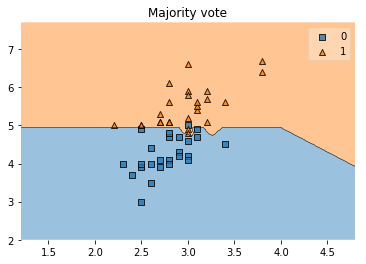

In [25]:
plot_decision_regions(x_train, y_train, clf=mv_clf)
plt.title('Majority vote')
plt.show()

In [26]:
mv_clf.get_params()

{'pipeline-1': Pipeline(memory=None,
      steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ['clf', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='warn',
           n_jobs=None, penalty='l2', random_state=1, solver='warn',
           tol=0.0001, verbose=0, warm_start=False)]]),
 'decisiontreeclassifier': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=0,
             splitter='best'),
 'pipeline-2': Pipeline(memory=None,
      steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ['clf', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=Non

In [27]:
from sklearn.model_selection import GridSearchCV

In [28]:
params = {'decisiontreeclassifier__max_depth': [1, 2],
         'pipeline-1__clf__C': [0.001, 0.1, 100]}

In [29]:
grid = GridSearchCV(estimator=mv_clf, param_grid=params,
                   cv=10, scoring='roc_auc')
grid.fit(x_train, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=MajorityVoteClassifier(classifiers=[Pipeline(memory=None,
     steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ['clf', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2'...',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform')]])],
            vote='classlabel', weights=None),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'decisiontreeclassifier__max_depth': [1, 2], 'pipeline-1__clf__C': [0.001, 0.1, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

### Bagging – building an ensemble of classifiers from bootstrap samples

In [40]:
from sklearn.ensemble import BaggingClassifier

In [41]:
tree = DecisionTreeClassifier(criterion='entropy', 
                             random_state=1,
                             max_depth=None)

In [42]:
bag = BaggingClassifier(base_estimator=tree,
                       n_estimators=500,
                       max_samples=1.0,
                       max_features=1.0,
                       bootstrap=True,
                       bootstrap_features=False,
                       n_jobs=1, random_state=1)

In [43]:
from sklearn.metrics import accuracy_score

In [44]:
tree = tree.fit(x_train, y_train)
y_train_pred = tree.predict(x_train)
y_test_pred = tree.predict(x_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)

print('Decision tree train/test accuracies %0.2f/%0.2f'%(tree_train,
                                                        tree_test))

Decision tree train/test accuracies 1.00/0.90


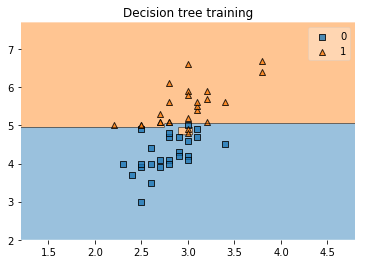

In [45]:
plot_decision_regions(x_train, y_train, clf=tree)
plt.title('Decision tree training')
plt.show()

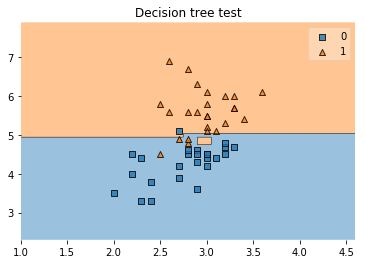

In [46]:
plot_decision_regions(x_test, y_test, clf=tree)
plt.title('Decision tree test')
plt.show()

In [47]:
bag = bag.fit(x_train, y_train)
y_train_predb = bag.predict(x_train)
y_test_predb = bag.predict(x_test)

bag_train = accuracy_score(y_train, y_train_predb)
bag_test = accuracy_score(y_test, y_test_predb)

print('Bagging train/test accuracies %0.2f/%0.2f'%(bag_train,
                                                  bag_test))

Bagging train/test accuracies 1.00/0.90


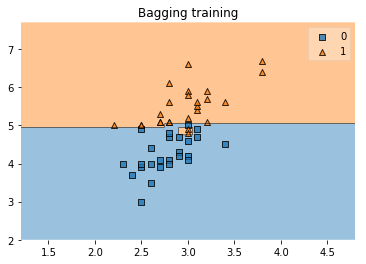

In [48]:
plot_decision_regions(x_train, y_train, clf=bag)
plt.title('Bagging training')
plt.show()

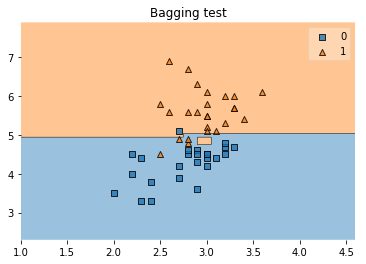

In [49]:
plot_decision_regions(x_test, y_test, clf=bag)
plt.title('Bagging test')
plt.show()

### Leveraging weak learners via adaptive boosting

In [50]:
from sklearn.ensemble import AdaBoostClassifier

In [51]:
tree1 = DecisionTreeClassifier(criterion='entropy', 
                             random_state=1,
                             max_depth=1)

In [52]:
ada = AdaBoostClassifier(base_estimator=tree,
                        n_estimators=500,
                        learning_rate=0.1,
                        random_state=1)

In [54]:
tree1 = tree1.fit(x_train, y_train)
y_train_pred1 = tree1.predict(x_train)
y_test_pred1 = tree1.predict(x_test)

tree1_train = accuracy_score(y_train, y_train_pred1)
tree1_test = accuracy_score(y_test, y_test_pred1)

print('Decision tree train/test accuracies %0.2f/%0.2f'%(tree1_train, tree1_test))

Decision tree train/test accuracies 0.94/0.90


In [55]:
ada = ada.fit(x_train, y_train)
y_train_pred2 = ada.predict(x_train)
y_test_pred2 = ada.predict(x_test)

tree1_train2 = accuracy_score(y_train, y_train_pred2)
tree1_test2 = accuracy_score(y_test, y_test_pred2)

print('AdaBoost train/test accuracies %0.2f/%0.2f'%(tree1_train2, tree1_test2))

AdaBoost train/test accuracies 1.00/0.90


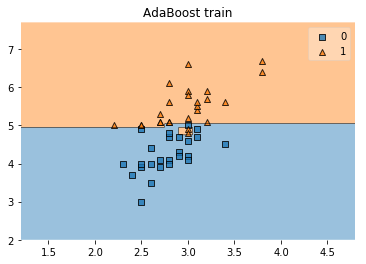

In [56]:
plot_decision_regions(x_train, y_train, clf=ada)
plt.title('AdaBoost train')
plt.show()

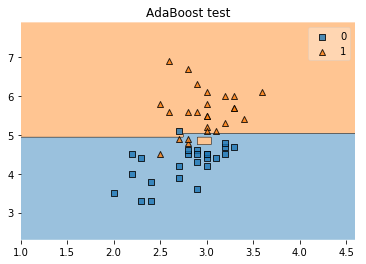

In [57]:
plot_decision_regions(x_test, y_test, clf=ada)
plt.title('AdaBoost test')
plt.show()